# Wikilink Graph - Part 1

In [8]:
import os
import requests
from bs4 import BeautifulSoup

In this blog, we will see how to programatically download wikipedia dumps from the internet.

We could have downloaded the data manually by going to the website [Wikipedia Dumps](https://dumps.wikimedia.org/), reading the text present to there to navigate through the hyperlinks to download the desired data.

That's no fun, so we are now going to do the same thing but programtically by requesting for the webpage present at the link and then parsing the page to extract the hyperlinks to do the same thing we did manually.

## Dump information

The first thing we will do is to get the dates of the dumps on the [wikipedia dumps](https://dumps.wikimedia.org/) website, the Wikimedia organization only hosts recent data dumps on their website and the older dumps could be found on [Internet Archive](https://archive.org/).

In this blog we will work with the English wikipedia dumps, so that is what is specified by `project='enwiki'`. We will request for the webpage at https://dumps.wikimedia.org/enwiki/ to get information on the dates. Below we can see the html file that was returned.

In [5]:
project = 'enwiki'
base_url = f'https://dumps.wikimedia.org/{project}/'
index = requests.get(base_url).text
index

'<html>\r\n<head><title>Index of /enwiki/</title></head>\r\n<body bgcolor="white">\r\n<h1>Index of /enwiki/</h1><hr><pre><a href="../">../</a>\r\n<a href="20220201/">20220201/</a>                                          21-Mar-2022 01:28                   -\r\n<a href="20220220/">20220220/</a>                                          02-Apr-2022 01:27                   -\r\n<a href="20220301/">20220301/</a>                                          02-May-2022 01:25                   -\r\n<a href="20220320/">20220320/</a>                                          02-May-2022 01:27                   -\r\n<a href="20220401/">20220401/</a>                                          07-Apr-2022 21:43                   -\r\n<a href="20220420/">20220420/</a>                                          22-Apr-2022 07:09                   -\r\n<a href="20220501/">20220501/</a>                                          12-May-2022 10:25                   -\r\n<a href="latest/">latest/</a>             

We will parse this html file to extract the dates of the dumps using `BeautifulSoup` library. 

Here we have created a `BeautifulSoup` object with the arguement `'html.parser'` specifying that we need to parse HTML file. The call to `soup_index.find_all('a')` returns all the `<a>` tags from the file from which we extract the links to the dumps of the specific date.

In [9]:
soup_index = BeautifulSoup(index, 'html.parser')
dumps = [ a.text for a in soup_index.find_all('a') if a.has_attr('href')]
dumps

['../',
 '20220201/',
 '20220220/',
 '20220301/',
 '20220320/',
 '20220401/',
 '20220420/',
 '20220501/',
 'latest/']

Once we have decided the date of the dumps to download based on the dates extract we can go ahead and request for the webpage specific to the date and then extract the links to the data dump that we will eventually be using to downloading the data.

Here we have decided to download the `20220420` dump. Below is the output of extracting the links present in the page.

In [12]:
dump_date = "20220420"

dump_url = base_url + dump_date
dump_html = requests.get(dump_url).text

soup_dump = BeautifulSoup(dump_html, 'html.parser')
soup_dump.find_all('li', {'class': 'file'}, limit=10)[:4]

[<li class="file"><a href="/enwiki/20220420/enwiki-20220420-pages-articles-multistream.xml.bz2">enwiki-20220420-pages-articles-multistream.xml.bz2</a> 19.3 GB</li>,
 <li class="file"><a href="/enwiki/20220420/enwiki-20220420-pages-articles-multistream-index.txt.bz2">enwiki-20220420-pages-articles-multistream-index.txt.bz2</a> 230.0 MB</li>,
 <li class="file"><a href="/enwiki/20220420/enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2">enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2</a> 247.4 MB</li>,
 <li class="file"><a href="/enwiki/20220420/enwiki-20220420-pages-articles-multistream-index1.txt-p1p41242.bz2">enwiki-20220420-pages-articles-multistream-index1.txt-p1p41242.bz2</a> 221 KB</li>]

In [14]:
files = []

for file in soup_dump.find_all('li', {'class': 'file'}):
    text = file.text
    files.append((text.split(' ')[0], text.split(' ')[1:]))
    
files[:4]

[('enwiki-20220420-pages-articles-multistream.xml.bz2', ['19.3', 'GB']),
 ('enwiki-20220420-pages-articles-multistream-index.txt.bz2', ['230.0', 'MB']),
 ('enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2',
  ['247.4', 'MB']),
 ('enwiki-20220420-pages-articles-multistream-index1.txt-p1p41242.bz2',
  ['221', 'KB'])]

In [16]:
file_to_download = [ file[0] for file in files 
                    if '.xml-p' in file[0] and 'pages-articles' in file[0] and 'multistream' in file[0]]
file_to_download[-5:]

['enwiki-20220420-pages-articles-multistream27.xml-p63975910p65475909.bz2',
 'enwiki-20220420-pages-articles-multistream27.xml-p65475910p66975909.bz2',
 'enwiki-20220420-pages-articles-multistream27.xml-p66975910p68475909.bz2',
 'enwiki-20220420-pages-articles-multistream27.xml-p68475910p69975909.bz2',
 'enwiki-20220420-pages-articles-multistream27.xml-p69975910p70585441.bz2']

## Download wikipedia dump

In [22]:
import sys
import ssl
import pandas as pd
import tensorflow as tf

ssl._create_default_https_context = ssl._create_unverified_context

In [23]:
data_paths = []
file_info = []

dataset_home = '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/'

for file in file_to_download:
    path = f'{dataset_home}/datasets/{file}'
    
    if not os.path.exists(path):
        data_paths.append( tf.keras.utils.get_file(origin=f'{dump_url}/{file}', cache_dir=dataset_home) )
    else:
        data_paths.append(path)
        
    file_size = os.stat(path).st_size/1e6
    file_articles = int(file.split('p')[-1].split('.')[0]) - int(file.split('p')[-2])
    file_info.append((file, file_size, file_articles))

In [24]:
pd.DataFrame(sorted(file_info, key=lambda x: x[1], reverse=True)[:4], columns=['filename', 'size (MB)', '--'])

,filename,size (MB),--
0,enwiki-20220420-pages-articles-multistream9.xm...,556.144802,1109141
1,enwiki-20220420-pages-articles-multistream10.x...,549.290108,1353963
2,enwiki-20220420-pages-articles-multistream11.x...,533.662197,1499999
3,enwiki-20220420-pages-articles-multistream8.xm...,512.258438,802148


In [25]:
print(f"Number of partitions : {len(file_info)}")

Number of partitions : 62


<AxesSubplot:>

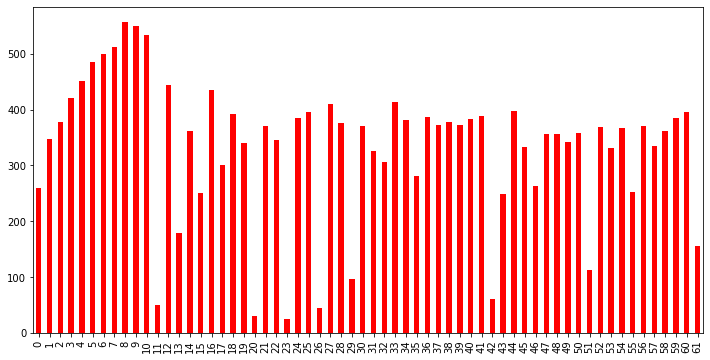

In [26]:
file_info_df = pd.DataFrame(file_info, columns=['filename', 'size (MB)', '--'])
file_info_df['size (MB)'].plot.bar(color='red', figsize=(12, 6))

In [27]:
print(f"Size of the total file : {file_info_df['size (MB)'].sum()/1e3:.2f} GB")

Size of the total file : 20.74 GB
